In [3]:
import pandas as pd
import numpy as np
import math
import sys
from IPython.display import display
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks

In [4]:
measures_multicriteria = ['ratio_selection_rate', 'ratio_recall', 'ratio_odds']

def multicriteria(measurement_values):
    pairs = list(combinations(measurement_values, 2))
    area = 0
    for a, b in pairs:
        area += (a*b*math.sin((2*math.pi)/3)/2)    
    return area

def multicriteria_validation(validation):
    matrix = validation[measures_multicriteria].to_numpy()
    validation['multicriteria'] = [multicriteria(row) for row in matrix]
    return validation

In [5]:
def results():
    measures = ['f1_macro', 'ratio_f1_macro', 'ratio_selection_rate', 'ratio_recall', 'ratio_odds']
    df = pd.DataFrame(columns = ['Dataset', 'Config', 'Selection'] + measures)

    count = 0

    for name in ['adult', 'arrhythmia', 'bank',  'compasmen', 'compaswomen', 'contraceptive',
                 'german', 'heart', 'student', 'titanic']:  
        for config in ['ad', 'dt', 'knn', 'mlp', 'rf', 'xgb']:

            validation = pd.read_csv('../Experiments/' + name + '_' + config + '_validation.csv', sep=';', index_col=0)
            validation['ratio_odds'] = (validation['ratio_fpr'] + validation['ratio_recall'])/2
            validation = multicriteria_validation(validation)

            test = pd.read_csv('../Experiments/' + name + '_' + config + '_test.csv', sep=';', index_col=0)
            test['ratio_odds'] = (test['ratio_fpr'] + test['ratio_recall'])/2
            test = multicriteria_validation(test) 

            idx_DIF = validation['DIF'].idxmin()
            idx_MC = validation['multicriteria'].idxmax()
            idx_DP = validation['ratio_selection_rate'].idxmax()

            dif = []
            multi = []
            single = []

            dif.append(name)
            multi.append(name)
            single.append(name)

            dif.append(config)
            multi.append(config)
            single.append(config)

            dif.append('ABC')
            multi.append('MCPM')
            single.append('Single')

            for measure in measures:
                dif.append(test.loc[idx_DIF, measure])
                multi.append(test.loc[idx_MC, measure])
                single.append(test.loc[idx_DP, measure])

            df.loc[count] = dif 
            count += 1
            df.loc[count] = multi 
            count += 1
            df.loc[count] = single
            count += 1
    return df

In [6]:
def cd(results, name):
    df = results[['ABC', 'MCPM', 'Single']]
    algorithms_names = df.columns
    results_array = df.values

    ranks_test = np.array([rankdata(-p) for p in results_array])

    average_ranks = np.mean(ranks_test, axis=0)
    print('\n'.join('({}) Média dos ranks: {}'.format(a, r) for a, r in zip(algorithms_names, average_ranks)))
    
    # This method computes the critical difference for Nemenyi test
    cd = compute_CD(average_ranks, n=len(df), alpha='0.05', test='nemenyi')
    print('CD = ', cd)
    # This method generates the plot.
    graph_ranks(average_ranks, names=algorithms_names, cd=cd, width=4, textspace=1.25, reverse=False, 
                filename = name + '.pdf')

## Reports

In [7]:
df = results()
df.groupby(by=['Config', 'Selection']).mean()

/tmp/ipykernel_7276/1583445205.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(by=['Config', 'Selection']).mean()


f1_macro  ratio_f1_macro  ratio_selection_rate  \
Config Selection                                                   
ad     ABC        0.715553        0.889234              0.731865   
       MCPM       0.718924        0.901783              0.758781   
       Single     0.718118        0.892980              0.720445   
dt     ABC        0.713032        0.933771              0.667146   
       MCPM       0.697446        0.886908              0.674199   
       Single     0.693967        0.886301              0.684310   
knn    ABC        0.661684        0.938495              0.586751   
       MCPM       0.642175        0.932968              0.701597   
       Single     0.648568        0.921627              0.712027   
mlp    ABC        0.735749        0.940488              0.636443   
       MCPM       0.728112        0.934733              0.660217   
       Single     0.730936        0.935219              0.632719   
rf     ABC        0.747160        0.957758              0.621893   
       MCPM       0.747410        0.945291              0.633881   
       Single     0.749099        0.934119              0.635534   
xgb    ABC        0.762598        0.970090              0.638437   
       MCPM       0.752803        0.961559              0.628939   
       Single     0.754228        0.963674              0.624743   

                  ratio_recall  ratio_odds  
Config Selection                            
ad     ABC            0.830068    0.696143  
       MCPM           0.852639    0.762786  
       Single         0.822676    0.706164  
dt     ABC            0.836944    0.708343  
       MCPM           0.824887    0.688432  
       Single         0.836220    0.708600  
knn    ABC            0.742129    0.602515  
       MCPM           0.837102    0.679734  
       Single         0.818253    0.688376  
mlp    ABC            0.833748    0.663357  
       MCPM           0.846156    0.706617  
       Single         0.827227    0.690035  
rf     ABC            0.868500    0.676984  
       MCPM           0.876009    0.686168  
       Single         0.874665    0.669485  
xgb    ABC            0.877577    0.742080  
       MCPM           0.864977    0.713266  
       Single         0.858295    0.707273

In [8]:
df.groupby(by=['Dataset', 'Selection']).mean()

/tmp/ipykernel_7276/1974995436.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(by=['Dataset', 'Selection']).mean()


f1_macro  ratio_f1_macro  ratio_selection_rate  \
Dataset       Selection                                                   
adult         ABC        0.788987        0.971356              0.323221   
              MCPM       0.784873        0.981524              0.335423   
              Single     0.785015        0.982467              0.336871   
arrhythmia    ABC        0.672184        0.908795              0.619707   
              MCPM       0.702738        0.897931              0.777395   
              Single     0.703751        0.880837              0.759852   
bank          ABC        0.723281        0.933548              0.540872   
              MCPM       0.723288        0.935570              0.538530   
              Single     0.719698        0.933588              0.551285   
compasmen     ABC        0.657338        0.976282              0.657809   
              MCPM       0.636631        0.967233              0.690831   
              Single     0.636378        0.967633              0.684953   
compaswomen   ABC        0.627755        0.933860              0.912893   
              MCPM       0.616800        0.914188              0.885508   
              Single     0.623549        0.914785              0.928925   
contraceptive ABC        0.657957        0.963257              0.918354   
              MCPM       0.642222        0.961297              0.940020   
              Single     0.650762        0.938299              0.910584   
german        ABC        0.653647        0.964915              0.832282   
              MCPM       0.621282        0.931859              0.836660   
              Single     0.615977        0.919011              0.847517   
heart         ABC        0.797357        0.936194              0.533539   
              MCPM       0.798228        0.900760              0.548819   
              Single     0.804005        0.905015              0.510917   
student       ABC        0.864938        0.930622              0.879428   
              MCPM       0.842014        0.907763              0.883713   
              Single     0.847800        0.917189              0.872632   
titanic       ABC        0.782851        0.864231              0.252786   
              MCPM       0.776707        0.873946              0.325792   
              Single     0.771260        0.864377              0.279427   

                         ratio_recall  ratio_odds  
Dataset       Selection                            
adult         ABC            0.863439    0.550046  
              MCPM           0.853228    0.563511  
              Single         0.853083    0.565691  
arrhythmia    ABC            0.750756    0.669868  
              MCPM           0.861840    0.745122  
              Single         0.838946    0.787094  
bank          ABC            0.870076    0.685380  
              MCPM           0.921836    0.727508  
              Single         0.902439    0.724982  
compasmen     ABC            0.774879    0.704656  
              MCPM           0.771112    0.736447  
              Single         0.766143    0.730115  
compaswomen   ABC            0.941848    0.862643  
              MCPM           0.880376    0.829303  
              Single         0.870104    0.822467  
contraceptive ABC            0.945904    0.914683  
              MCPM           0.941136    0.884734  
              Single         0.920161    0.857552  
german        ABC            0.884329    0.804915  
              MCPM           0.897936    0.818031  
              Single         0.912678    0.826043  
heart         ABC            0.876714    0.610976  
              MCPM           0.900992    0.684127  
              Single         0.884028    0.598264  
student       ABC            0.974084    0.740653  
              MCPM           0.968344    0.703804  
              Single         0.961739    0.723925  
titanic       ABC            0.432913    0.271881  
              MCPM           0.506151    0.369084  
            

In [9]:
df.groupby(by=['Selection']).mean()

/tmp/ipykernel_7276/4116396812.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(by=['Selection']).mean()


,f1_macro,ratio_f1_macro,ratio_selection_rate,ratio_recall,ratio_odds
Selection,,,,,
ABC,0.722629,0.938306,0.647089,0.831494,0.681570
MCPM,0.714478,0.927207,0.676269,0.850295,0.706167
Single,0.715819,0.922320,0.668296,0.839556,0.694989


## Statistical test

In [18]:
def statistical(measure):

    df_statistical = pd.DataFrame(columns = ['ABC', 'MCPM', 'Single'])

    count = 0

    for name in ['adult', 'arrhythmia', 'bank',  'compasmen', 'compaswomen', 'contraceptive',
                 'german', 'heart', 'student', 'titanic']:    
        for config in ['ad', 'dt', 'knn', 'mlp', 'rf', 'xgb']:

            validation = pd.read_csv('../Experiments ICMLA/' + name + '_' + config + '_validation.csv', sep=';', index_col=0)
            validation['ratio_odds'] = (validation['ratio_fpr'] + validation['ratio_recall'])/2
            validation = multicriteria_validation(validation)

            test = pd.read_csv('../Experiments ICMLA/' + name + '_' + config + '_test.csv', sep=';', index_col=0)
            test['ratio_odds'] = (test['ratio_fpr'] + test['ratio_recall'])/2
            test = multicriteria_validation(test) 

            idx_DIF = validation['DIF'].idxmin()
            idx_MC = validation['multicriteria'].idxmax()
            idx_DP = validation['ratio_selection_rate'].idxmax()

            df_statistical.loc[count] = [test.loc[idx_DIF, measure], test.loc[idx_MC, measure],
                                  test.loc[idx_DP, measure]]
            count += 1
    return df_statistical

(ABC) Média dos ranks: 1.6416666666666666
(MCPM) Média dos ranks: 2.25
(Single) Média dos ranks: 2.1083333333333334
CD =  0.42789930191580505


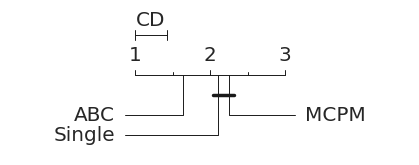

In [19]:
# f1_macro
sns.set(font_scale=1.2)
df_statistical = statistical('f1_macro')
cd(df_statistical, 'cd_f1_macro')

(ABC) Média dos ranks: 1.85
(MCPM) Média dos ranks: 2.066666666666667
(Single) Média dos ranks: 2.0833333333333335
CD =  0.42789930191580505


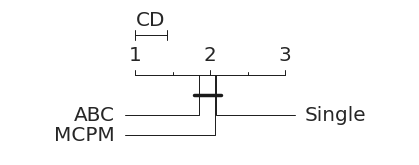

In [20]:
# ratio f1_macro
df_statistical = statistical('ratio_f1_macro')
cd(df_statistical, 'cd_ratio_f1_macro')

(ABC) Média dos ranks: 2.2416666666666667
(MCPM) Média dos ranks: 1.7833333333333334
(Single) Média dos ranks: 1.975
CD =  0.42789930191580505


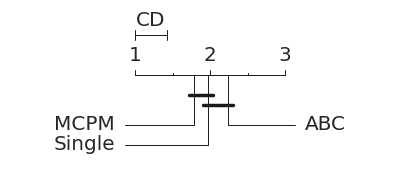

In [21]:
# demographic parity
df_statistical = statistical('ratio_selection_rate')
cd(df_statistical, 'cd_demographic_parity')

(ABC) Média dos ranks: 1.9083333333333334
(MCPM) Média dos ranks: 1.9333333333333333
(Single) Média dos ranks: 2.158333333333333
CD =  0.42789930191580505


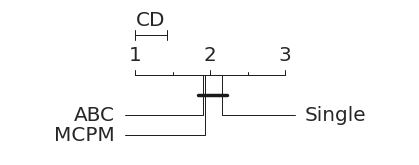

In [22]:
# equal opportunity
df_statistical = statistical('ratio_recall')
cd(df_statistical, 'cd_recall')

(ABC) Média dos ranks: 2.025
(MCPM) Média dos ranks: 1.9333333333333333
(Single) Média dos ranks: 2.0416666666666665
CD =  0.42789930191580505


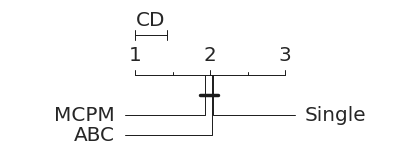

In [23]:
# equalized odds
df_statistical = statistical('ratio_odds')
cd(df_statistical, 'cd_odds')

## Visualization

In [10]:
new_df = df.groupby(by=['Dataset', 'Config', 'Selection']).mean().reset_index()
df_visualization = pd.DataFrame(columns = ['Algorithm', 'Model Selection', 'Measure', 'Value'])

count = 0
for row in new_df.iterrows():
    for measure in ['f1_macro', 'ratio_f1_macro', 'ratio_selection_rate', 'ratio_recall', 'ratio_odds']:
        df_visualization.loc[count] = [row[1]['Config'], row[1]['Selection'], measure, row[1][measure]]
        count += 1

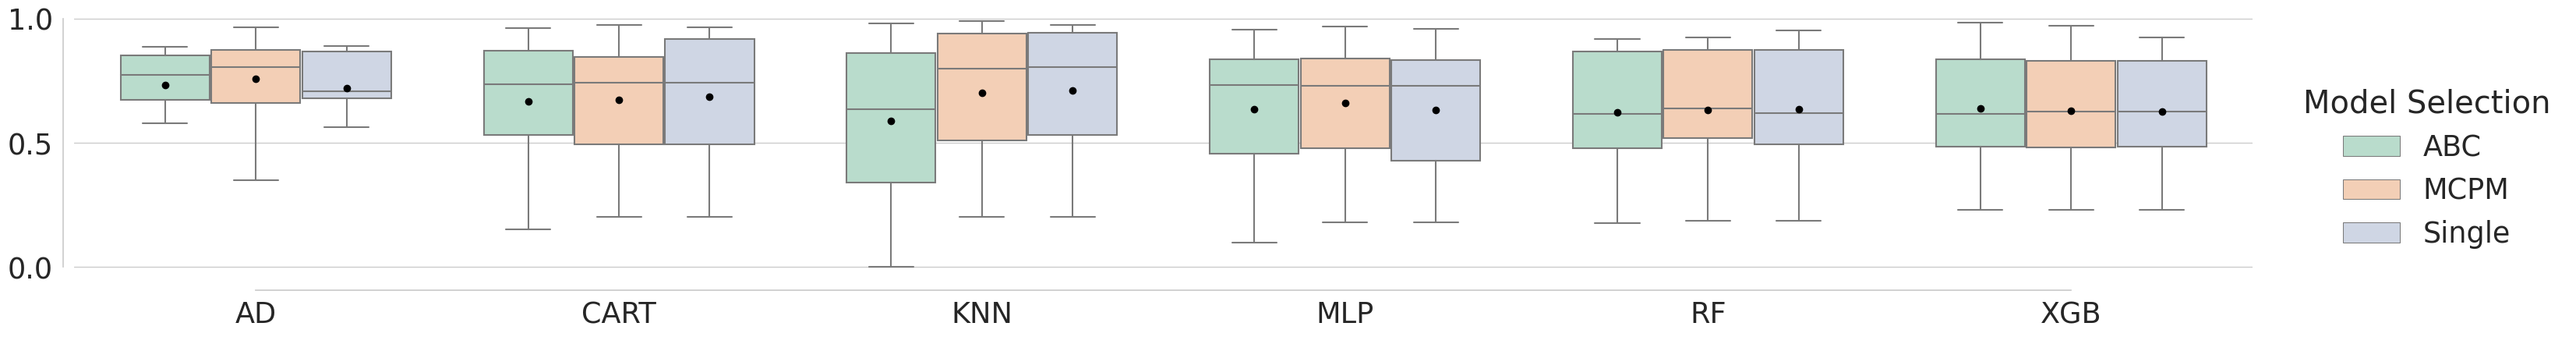

In [11]:
df_visualization1 = df_visualization.loc[df_visualization['Measure'] == 'ratio_selection_rate']

sns.set(style="ticks")
sns.set(font_scale=2.4)
sns.set_style("whitegrid")

g = sns.catplot(
    data=df_visualization1, x='Algorithm', y='Value', width=0.75, showmeans=True, showfliers = False, 
    legend=True, legend_out=True,
    meanprops={"marker":"o","markerfacecolor":"black", "markeredgecolor":"black"},
    hue='Model Selection' , kind='box', palette='Pastel2', height=5, aspect=6,
)

g.set_xticklabels(['AD', 'CART', 'KNN', 'MLP', 'RF', 'XGB'])
g.set(xlabel=None)
g.set(ylabel='')
g.set(title=None)

sns.despine(trim=True, offset=10)
g.tight_layout()

g.savefig("demographic_parity.pdf")